# Topic Modeling for Airline Customer Reviews
##Purpose
The purpose of this project is to leverage Unsupervised Learning moodels to find the most relevant topics from customer reviews with low satisfaction.
Finding the most proeminent topics is key to help companies identify and address recurring or outstanding issues in their operations. By leveraging Unsupervised Learning Models to find topics we are exponentially reducing the cost of categorizing customer feedback which alternativelly would be done manually by agents and can further be used by supervised learning models.

## About the data
For this project, I'm creating a new dataset by combining customer reviews from 3 different datasets from Kaggle:


*   [Air France TripAdvisor Reviews Dataset](https://www.kaggle.com/datasets/saharnazyaghoobpoor/air-france-reviews-dataset/data)
*   [Air India TripAdvisor Reviews Dataset](https://www.kaggle.com/datasets/kanchana1990/air-india-tripadvisor-reviews)
*   [British Airways AirQuality Customer Feedback Dataset](https://www.kaggle.com/datasets/chaudharyanshul/airline-reviews)


The combined dataset has 4 columns:

## Data Dictionary


*   **title**: The title of the review, summarizing the passenger's experience.
*   **text**: The full text of the review, detailing the passenger's feedback and experiences.
*   **rating**: The review rating, indicative of the customer's level of satisfaction. FIltered to low scores only: 1,2.
*   **airline**: The airline which was reviewed by the customer. Directly linked to the dataset source (Air France, Air India, British Airways).

author: Bruno Velleca repository link: CSCA6532


## 1.Building the Dataset
We'll first import the datasets from Kaggle, filter to negative customer reviews only. For Air India and Air France, ratings 1 and 2 (out of 5) were included. For British Airways, the original score was from 1 to 10, so 1 to 4 was included and then divided by 2 and round up to match the scores from the other datasets.

In [2]:
#hiding alerts
import warnings
warnings.filterwarnings('ignore')

#importing relevant libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
!pip install bertopic
from bertopic import BERTopic

In [7]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

#importing and unzipping datasets

!kaggle datasets download saharnazyaghoobpoor/air-france-reviews-dataset
!unzip air-france-reviews-dataset.zip

!kaggle datasets download kanchana1990/air-india-tripadvisor-reviews
!unzip air-india-tripadvisor-reviews.zip

!kaggle datasets download chaudharyanshul/airline-reviews
!unzip airline-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/saharnazyaghoobpoor/air-france-reviews-dataset
License(s): ODC Attribution License (ODC-By)
Archive:  air-france-reviews-dataset.zip
  inflating: airfrance_tripadvisor_reviews.csv  
Dataset URL: https://www.kaggle.com/datasets/kanchana1990/air-india-tripadvisor-reviews
License(s): ODC Attribution License (ODC-By)
Archive:  air-india-tripadvisor-reviews.zip
  inflating: air_india_reviews.csv   
Dataset URL: https://www.kaggle.com/datasets/chaudharyanshul/airline-reviews
License(s): MIT
Archive:  airline-reviews.zip
  inflating: BA_AirlineReviews.csv   


In [8]:
#filtering low rated reviews and combining datasets

# import pandas as pd
# import random

#air_india reviews
ai_columns = ['title', 'text', 'rating']
ai_df = pd.read_csv('air_india_reviews.csv')
ai_df = ai_df[ai_df['rating'] < 3]
ai_df = ai_df[ai_df['type'] == 'review'][ai_columns]
ai_df['airline'] = 'Air India'

# ai_df.head()

#air_france reviews
af_columns = ['title', 'text', 'rating']
af_df = pd.read_csv('airfrance_tripadvisor_reviews.csv')
af_df = af_df[af_df['rating'] < 3][af_columns]
af_df['airline'] = 'Air France'

# af_df.head()

#british airways
import math
ba_columns = ['ReviewHeader', 'ReviewBody', 'OverallRating']
ba_df = pd.read_csv('BA_AirlineReviews.csv')
ba_df = ba_df[ba_df['OverallRating'] < 5][ba_columns] #BA ratings go from 1 to 10
ba_df['OverallRating'] = (ba_df['OverallRating'] / 2).apply(lambda x: math.ceil(x)) #divide rating by 2 and round up
# ba_df['OverallRating'] = ba_df['OverallRating'].apply(lambda x: round(x))
#rename columns
ba_df = ba_df.rename(columns={'ReviewHeader': 'title', 'ReviewBody': 'text', 'OverallRating': 'rating'})
ba_df['airline'] = 'British Airways'

# ba_df.head()

#combining datasets & shuffling the order
#seed to keep the change

random.seed(42)
df_reviews = pd.concat([ai_df, af_df, ba_df])
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)
df_reviews.head()


,title,text,rating,airline
0,"""very poor and disappointing experience""",Gatwick to Mauritius. Very disappointing airli...,2,British Airways
1,Very Poor flight on Air India Regional,This has easily been the worst airline I've fl...,2,Air India
2,Appauling service!!!! Never again,Flew back with them at the end of a business t...,1,Air India
3,Avoid at all costs.,If I could give this airline negative stars I ...,1,Air India
4,Don't fly Air India if you want quality,Air India was one of the best airlines in the ...,1,Air India


In [9]:
#dowload dataset
pd.DataFrame(df_reviews).to_csv('airline_bad_reviews.csv', index=False)

## 2.Exploratory Data Analysis
Because we merged different datasets together, we want be sure they are not so drastically different to impact the performance of our models. We'll start by checking  how many observations in total per data source, and then checking word count distribution for text and title by airline

### 2.1. Data Visualization & Cleaning

In [5]:
#counting the length of text & title
df_reviews['text_length'] = df_reviews['text'].astype(str).apply(len)
df_reviews['title_length'] = df_reviews['title'].astype(str).apply(len)

airlines = df_reviews['airline'].unique()

review_count = df_reviews['airline'].value_counts()
total_count = df_reviews.shape[0]
review_count['Total'] = total_count

# avg word count per article per airline
# df_train['word_count'] = df_train['Text'].apply(lambda x: len(x.split()))
word_count = df_reviews.groupby('airline')['text_length'].mean()
word_count['Total'] = df_reviews['text_length'].mean()

#shortest word count per airline
min_word_count = df_reviews.groupby('airline')['text_length'].min()
min_word_count['Total'] = df_reviews['text_length'].min()

#longest word count per airline
max_word_count = df_reviews.groupby('airline')['text_length'].max()
max_word_count['Total'] = df_reviews['text_length'].max()

#building a summary table
summary_table = pd.concat([review_count, word_count.map('{:.1f}'.format), min_word_count, max_word_count], axis=1)
summary_table.columns = ['Article Count', 'Avg Word Count', 'Min Word Count', 'Max Word Count']
summary_table

,Article Count,Avg Word Count,Min Word Count,Max Word Count
airline,,,,
Air India,2564,708.3,100,6934
British Airways,1949,965.3,100,3529
Air France,914,838.8,100,8727
Total,5427,822.6,100,8727


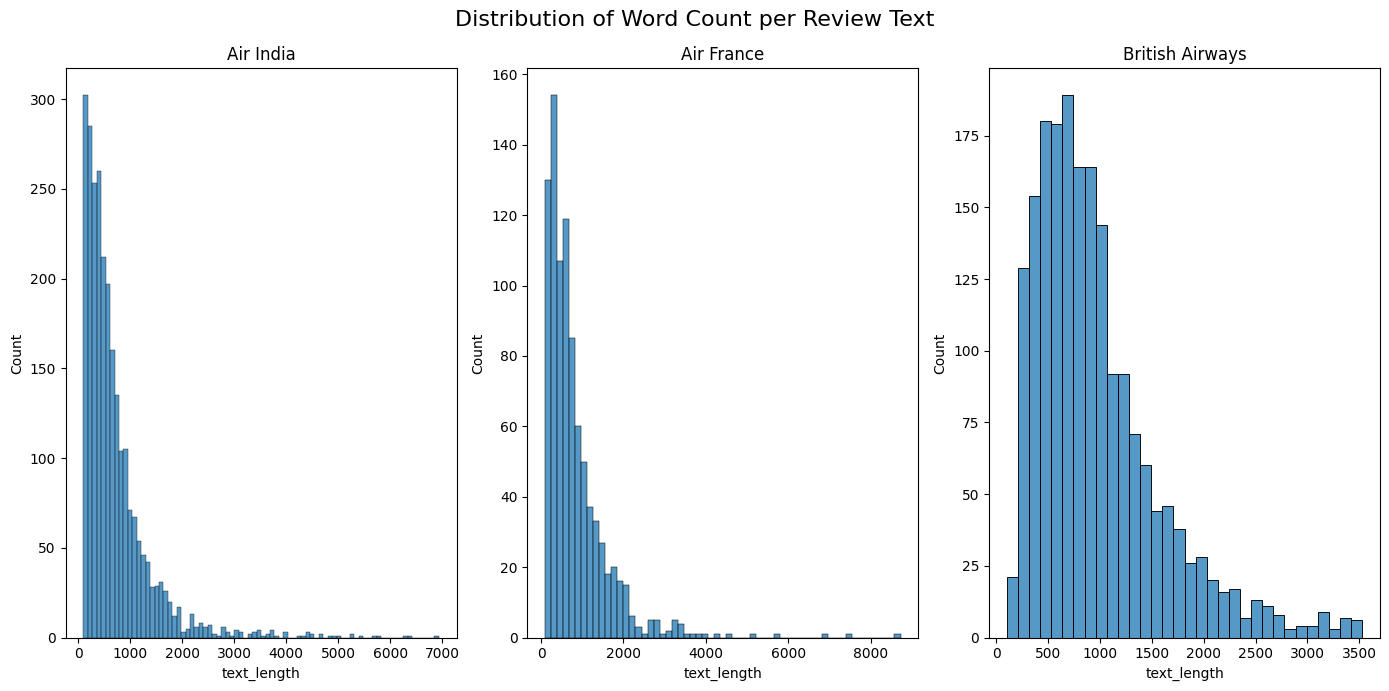

In [6]:
#distrution of the word count by airline to check length similarity
# import matplotlib.pyplot as plt
# import seaborn as sns
fig, axs = plt.subplots(1, 3, figsize=(14,7))
fig.suptitle('Distribution of Word Count per Review Text', fontsize=16)

for i, airline in enumerate(airlines):
    ax = axs[i]
    sns.histplot(data=df_reviews[df_reviews['airline'] == airline], x='text_length', ax=ax, label='Text')
    ax.set_title(airline)

plt.tight_layout()
plt.show()


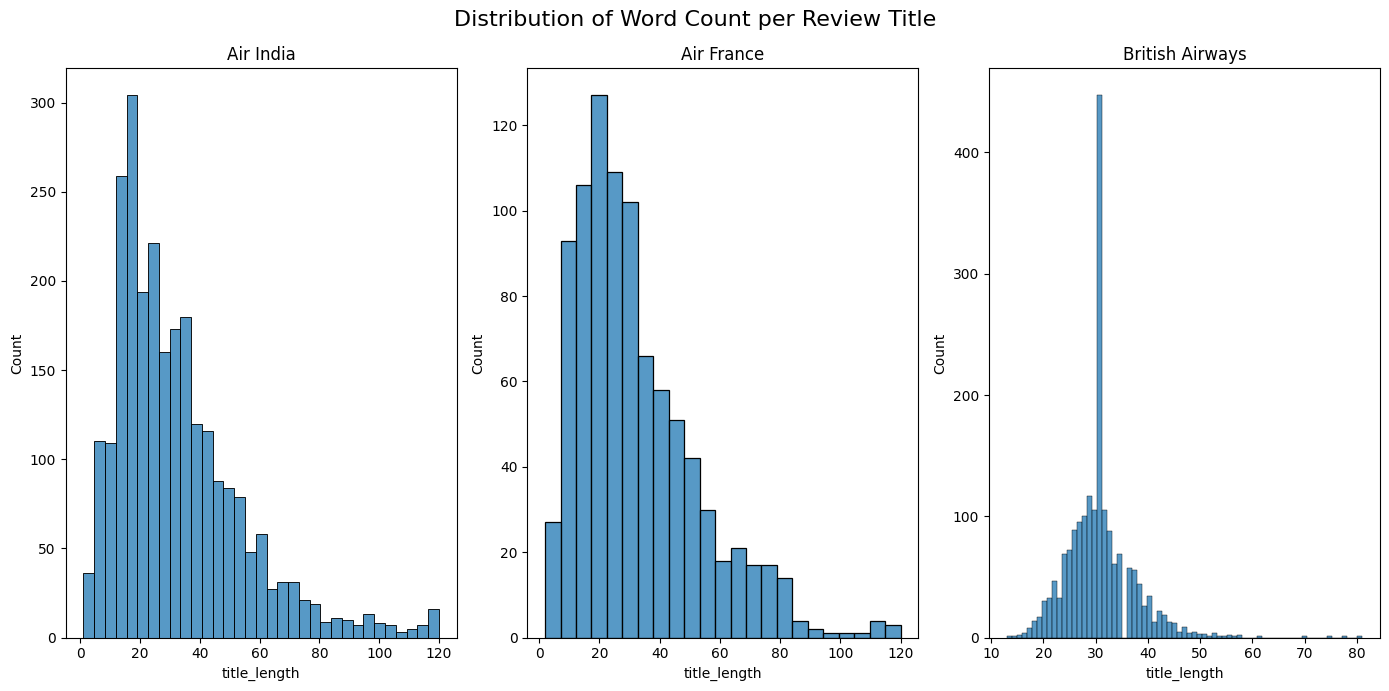

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
fig.suptitle('Distribution of Word Count per Review Title', fontsize=16)

for i, airline in enumerate(airlines):
    ax = axs[i]
    sns.histplot(data=df_reviews[df_reviews['airline'] == airline], x='title_length', ax=ax, label='Title')
    ax.set_title(airline)

plt.tight_layout()
plt.show()

When looking at the distribution, we can see that Air India has almost 50% of the observations, the max text length for British Airways reviews are 3500 words while the other reviews have a much longer tail (going all the way up to 8700 words) and finally there is an anomally with the length of the text titles for British Airways reviews. We'll do the following to clean the data:
* Remove reviews that are longer than 3500 words
* Remove reviews with the title "British Airways customer review" - check the evaluation table below
* Randomize the number of Air India observations and reduce it to 1500 to be equivalent to British Airways dataset.

In [8]:
#count of reviews longer than 3500 words by airline
print("Reviews with more than 3500 words: ")
print(df_reviews[df_reviews['text_length'] > 3500]['airline'].value_counts())
print('\n')
# Create a DataFrame from the top 10 titles
print('Top Titles for Reviews')
top_titles = df_reviews['title'].value_counts().head(5)
top_titles_df = pd.DataFrame(top_titles).reset_index()

# Rename the columns for clarity
top_titles_df.columns = ['Title', 'Frequency']

# Display the table
print(top_titles_df)

Reviews with more than 3500 words: 
airline
Air India          31
Air France         11
British Airways     2
Name: count, dtype: int64


Top Titles for Reviews
                             Title  Frequency
0  British Airways customer review        355
1                 Worst experience         24
2                         Horrible         17
3                         Terrible         13
4                      Never again         12


In [9]:
#cleaning the dataset

df_reviews = df_reviews[(df_reviews['text_length'] < 3500) & (df_reviews['title'] != 'British Airways customer review')]

#randomize and remove 1000 Air India observations
air_india_df = df_reviews[df_reviews['airline'] == 'Air India']
air_india_df = air_india_df.sample(n=1500, random_state=42)

df_reviews = df_reviews[df_reviews['airline'] != 'Air India']
df_reviews = pd.concat([df_reviews, air_india_df])
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)

#number of reviews by airline
print ('Cleaned Dataset')
print(df_reviews['airline'].value_counts())

Cleaned Dataset
airline
British Airways    1592
Air India          1500
Air France          903
Name: count, dtype: int64


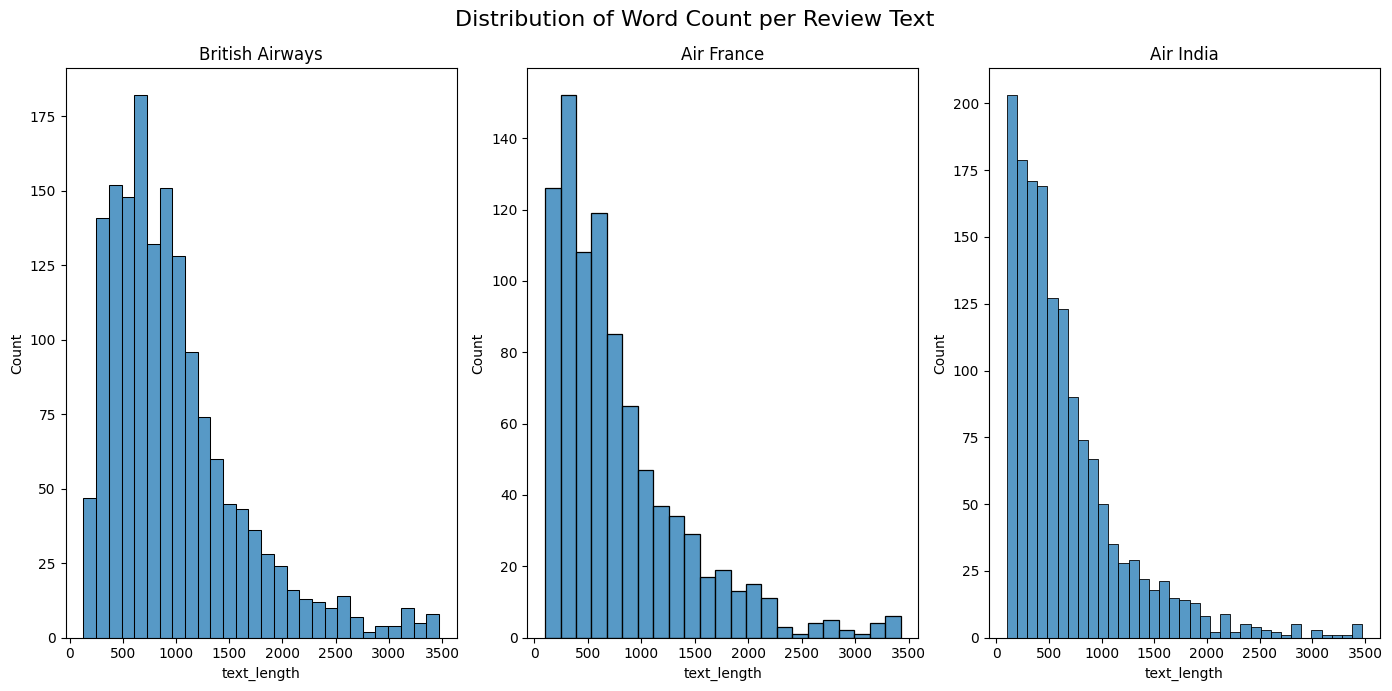

In [10]:
#distrution of the word count by airline to check length similarity
df_reviews['text_length'] = df_reviews['text'].astype(str).apply(len)
df_reviews['title_length'] = df_reviews['title'].astype(str).apply(len)

airlines = df_reviews['airline'].unique()

fig, axs = plt.subplots(1, 3, figsize=(14,7))
fig.suptitle('Distribution of Word Count per Review Text', fontsize=16)

for i, airline in enumerate(airlines):
    ax = axs[i]
    sns.histplot(data=df_reviews[df_reviews['airline'] == airline], x='text_length', ax=ax, label='Text')
    ax.set_title(airline)

plt.tight_layout()
plt.show()


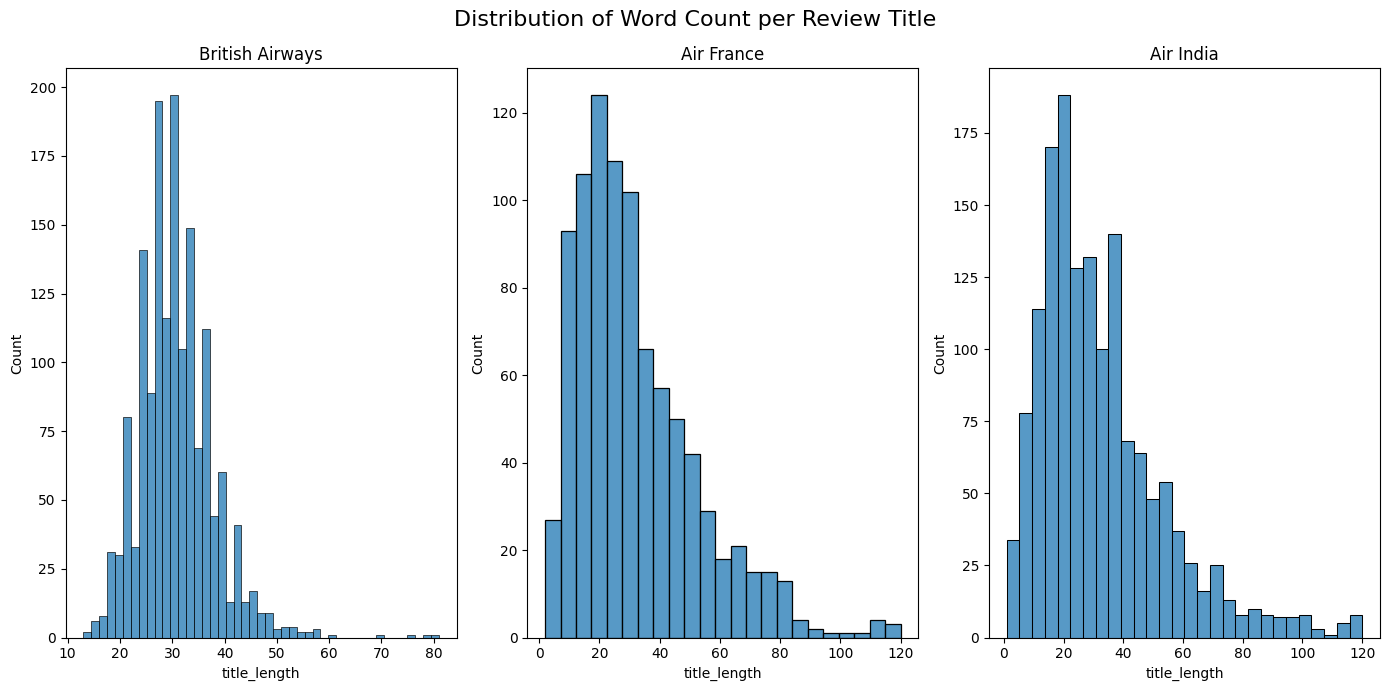

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
fig.suptitle('Distribution of Word Count per Review Title', fontsize=16)

for i, airline in enumerate(airlines):
    ax = axs[i]
    sns.histplot(data=df_reviews[df_reviews['airline'] == airline], x='title_length', ax=ax, label='Title')
    ax.set_title(airline)

plt.tight_layout()
plt.show()

### 2.2. Feature Cleaning (Text Processing & Normalization)
After removing the outstading data sets, we need to clean the text reviews and normalize the features to ensure we can use Unsupervised Learning methods to find the most relevant topics of complaint by airline customers.

We'll clean the data by:


*   Lowercasing all words;
*   Removing special characters;
*   Removing numbers;
*   Removing stopwords;
*   Removing the names and accronyms of airlines and specific keywords;
*   Removing the city names;
*   Removing iata codes for all airports;
*   Removing the names of the airports;
*   Tokenize and lemmatize the words.

It is important to notice that the outcome of this notebook is the result of several iterations on the cleaning process, and the specific keywords listed were added after every iteration of the models, trying to improve the quality of the topics.

The cleaning method was adapted from this [Kaggle notebook](https://www.kaggle.com/code/sahityasetu/topic-modelling-on-reviews-dataset?scriptVersionId=228218289&cellId=14).



In [15]:
# import re
# import spacy
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize


#loading database of airport names and codes to remove from the relevant corpus of data
airports_csv = pd.read_csv('https://raw.githubusercontent.com/mborsetti/airportsdata/main/airportsdata/airports.csv')
relevant_columns = ['city','iata','name']
airports = airports_csv[relevant_columns].copy()

airports.loc[:, 'city'] = airports['city'].astype(str).str.lower()
airports.loc[:, 'iata'] = airports['iata'].astype(str).str.lower()
airports.loc[:, 'name'] = airports['name'].astype(str).str.lower()

#replace the term airport in airport names
airports['name'] = airports['name'].str.replace('airport', '')

#transforming both columns in an array to join to stopwords
airports_city = airports['city'].to_numpy()
airports_iata = airports['iata'].to_numpy()
airports_name = airports['name'].to_numpy()

# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

def clean_text_spacy(text):
    if not isinstance(text, str):
        return ""
    # Lowercase and remove special characters and numbers
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize using spaCy and lemmatize
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]

    # Remove stopwords (you can use spaCy's stopwords as well)
    stop_words = set(stopwords.words('english'))
    airline_words = ['air', 'france', 'india', 'british', 'airways','ba', 'af',
                     'ai', 'heathrow','gatwick','mauritius','easyjet','i','I']
    stop_words.update(airline_words)
    stop_words.update(airports_city)
    stop_words.update(airports_iata)
    stop_words.update(airports_name)
    tokens = [word for word in tokens if word not in stop_words]
    # tokens = [word for word in tokens if word not in stopwords.words('english')]

    return ' '.join(tokens)

# Apply the new preprocessing function
df_reviews['cleaned_text'] = df_reviews['text'].apply(clean_text_spacy)

#dowload cleaned_reviews csv
# df_reviews.to_csv('cleaned_reviews.csv', index=False)

### Feature Cleaning Impact Visualization
We can start assessing the effectiveness of the feature cleaning, printing some examples side by side.

We can see below how the name of the airline companies has been removed, together with stopwords and words have been tokenized. By looking at the charts, we were able to reduce the number of words by 1/3 with this process, going from 35k to 10k words/tokens. This is already a huge improvement before normalizing the reviews.

In the airline industry we also need to pay attention to bigrams, and we can see in the last set of charts how relevant the bigrams are now, show expressions like "customer service, "flight delay", business class, etc.

With this preparation work, we are ready to normalize the data for our models.

In [3]:
# load = pd.read_csv('cleaned_reviews.csv')
# df_reviews = load.copy()

In [4]:
df_reviews[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Absolutely appalling service from BA! I booked...,absolutely appalling service book seat extra l...
1,We took flight from Mumbai to Paris on 8th Sep...,take flight th sept long flight horrible exper...
2,The flight experience out to Lima from Amsterd...,flight experience great comfortable seat good ...
3,Only good point : flight was on time and board...,good flight time boarding good organise food t...
4,The service is got super inconsistent on BA an...,service super inconsistent management divert f...


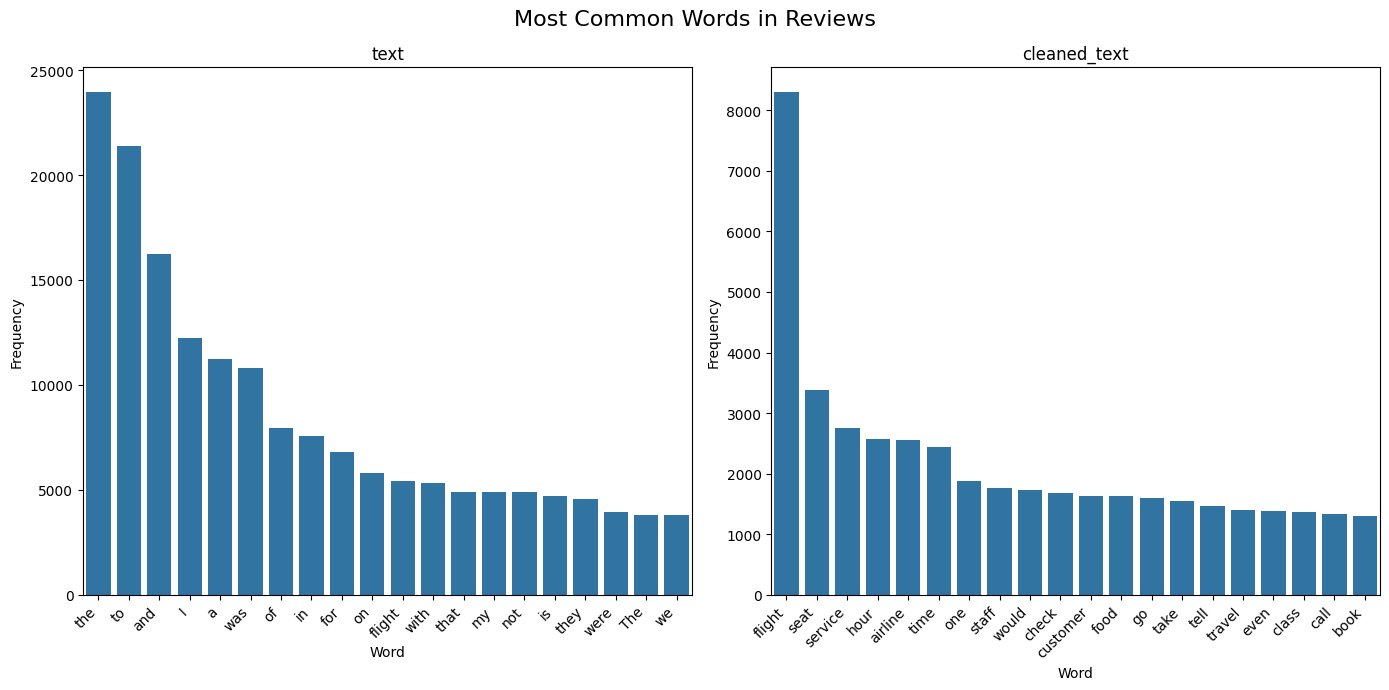

Number of words in text: 34864
Number of words in cleaned_text: 10115


In [5]:
#dictionary of most common words
relevant_words ={}
columns = ['text', 'cleaned_text']

for column in columns:
  relevant_words[column] = {}
  for word in df_reviews[column].str.split().explode():
    if word not in relevant_words[column]:
      relevant_words[column][word] = 1
    else:
      relevant_words[column][word] += 1
  relevant_words[column] = {k: v for k, v in sorted(relevant_words[column].items(), key=lambda item: item[1], reverse=True)}
  relevant_words[column] = list(relevant_words[column].items())
  relevant_words[column] = pd.DataFrame(relevant_words[column], columns=['Word', 'Frequency'])


#plotting the most common word before and after cleaning
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Most Common Words in Reviews', fontsize=16)

for i, column in enumerate(columns):
    ax = axs[i]
    sns.barplot(data=relevant_words[column].head(20), x='Word', y='Frequency', ax=ax)
    ax.set_title(column)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#count of words per columns
for column in columns:
  print(f"Number of words in {column}: {len(relevant_words[column])}")


With this process we were able to reduce the number of words by 1/3. From 35k to 10k. Which is already a huge improvement before normalizing the reviews.

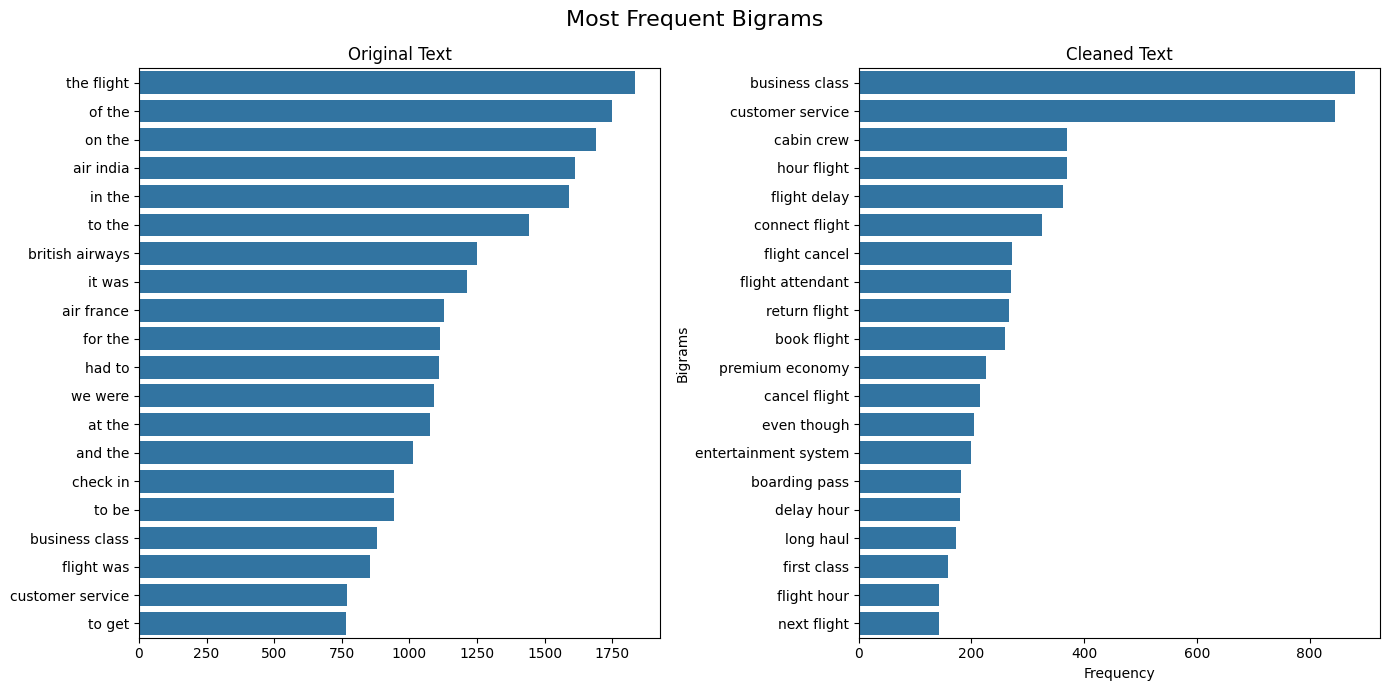

In [6]:
#checking bigrams
# from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer( ngram_range=(2,2), max_features=20)
text_counter = vectorizer.fit_transform(df_reviews['text'])
text_freq = dict(zip(vectorizer.get_feature_names_out(), text_counter.toarray().sum(axis=0)))
text_freq = {k: v for k, v in sorted(text_freq.items(), key=lambda item: item[1], reverse=True)}

cleaned_counter = vectorizer.fit_transform(df_reviews['cleaned_text'])
cleaned_freq = dict(zip(vectorizer.get_feature_names_out(), cleaned_counter.toarray().sum(axis=0)))
cleaned_freq = {k: v for k, v in sorted(cleaned_freq.items(), key=lambda item: item[1], reverse=True)}

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Most Frequent Bigrams', fontsize=16)

sns.barplot(x=list(text_freq.values()), y=list(text_freq.keys()), ax=axs[0])
axs[0].set_title('Original Text')

sns.barplot(x=list(cleaned_freq.values()), y=list(cleaned_freq.keys()), ax=axs[1])
axs[1].set_title('Cleaned Text')

plt.xlabel("Frequency")
plt.ylabel("Bigrams")

plt.tight_layout()
plt.show()


## 3.Building the Models

### 3.1. Feature Normalization
We will use TF-IDF to normalize the data. TF_IDF is a statistical method used in information retrieval and natural language processing to evaluate how important a word is to a document within a collection of documents. This is a crucial step to using Non-negative Matrix Factorization in the future.
There are 3 hyperparameters we want to adjust based on the selected model (NMF):
1. ngram_range
2. min_df
3. max_df

#### 3.3.1. ngram_range
Based on the analysis of bigrams done during the EDA process, we want to consider bigrams, so the `ngram_range = (1,2)`.

This means that our model will consider not only singular word, but word combinations, making the number of features grow exponentialy as seen below (from 10k to 150k):



In [7]:
#showing the difference in number of features by adding bigrams to our analysis

tfidf_vectorizer1 = TfidfVectorizer(ngram_range=(1,1))
tfidf_matrix = tfidf_vectorizer1.fit_transform(df_reviews['cleaned_text'])
number_of_features1 = tfidf_vectorizer1.get_feature_names_out().shape[0]

tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer2.fit_transform(df_reviews['cleaned_text'])
number_of_features2 = tfidf_vectorizer2.get_feature_names_out().shape[0]

print(f"Number of features without bigrams: {number_of_features1}")
print(f"Number of features with bigrams: {number_of_features2}")

Number of features without bigrams: 10079
Number of features with bigrams: 150273


#### 3.3.2. min_df
Because the number of our features is so large now, we need to specify a minimum threshold for our terms to be considered relevant. `min_df` specifies the minimum number of documents a term must appear in to be included in the vocabulary.To find a reasonable number we'll iterate from 1 to 20 documents.

Based on the analysis, well select `min_df = 10` for our model.

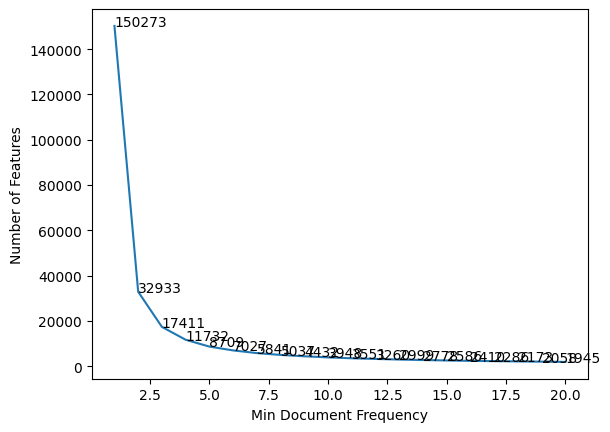

In [8]:
#checking how many features we get by reducing the min_df during vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
min_df_values =[i for i in range(1,21,1)]
min_df_values
n_features = []
for min_df in min_df_values:
  tfidf_vectorizer = TfidfVectorizer(min_df=min_df, ngram_range=(1,2))
  tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['cleaned_text'])
  number_of_features = tfidf_vectorizer.get_feature_names_out().shape[0]
  n_features.append(number_of_features)

plt.plot(min_df_values, n_features)
plt.xlabel('Min Document Frequency')
plt.ylabel('Number of Features')
#adding the numbers to the chart
for i, txt in enumerate(n_features):
    plt.annotate(txt, (min_df_values[i], n_features[i]))
plt.show()

#### 3.3.3 max_df
Now we want to ensure we are reducing the terms that appear too often in our documentation. To do so, we will set `min_df = 10` and will iterate on the maximum number of documents a term can appear in to be included in the vocabulary. For max_df we are using percentages instead of setting a specific number target.

Based on the analysis, we'll select `max_df = 0.2` for our model:

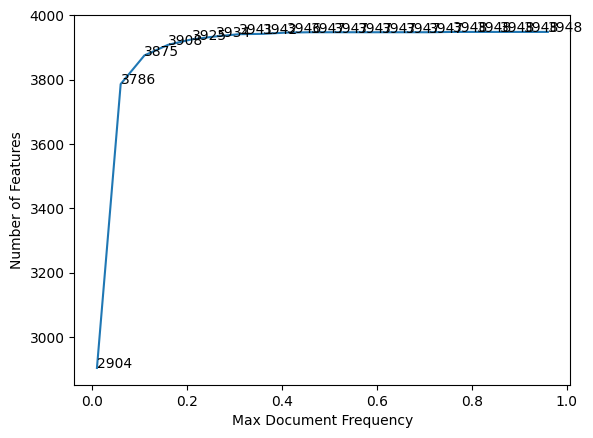

In [9]:
#checking how many features we get by reducing the max_df during vectorization
# from sklearn.feature_extraction.text import TfidfVectorizer
max_df_values =[i/100 for i in range(1,101,5)]

n_features = []
for max_df in max_df_values:
  tfidf_vectorizer = TfidfVectorizer(max_df=max_df, ngram_range=(1,2), min_df=10)
  tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['cleaned_text'])
  number_of_features = tfidf_vectorizer.get_feature_names_out().shape[0]
  n_features.append(number_of_features)

plt.plot(max_df_values, n_features)
plt.xlabel('Max Document Frequency')
plt.ylabel('Number of Features')
#adding the numbers to the chart
for i, txt in enumerate(n_features):
    plt.annotate(txt, (max_df_values[i], n_features[i]))
plt.show()

Finally, with the hyperparameters selected we can normalize the data, ending up with 3932 features for our model as display below:

In [10]:
# Initialize the TF-IDF vectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.20, min_df = 10, ngram_range=(1,2))
# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['cleaned_text'])
number_of_features = tfidf_vectorizer.get_feature_names_out().shape[0]
print (f"Number of features: {number_of_features}")

Number of features: 3921


### 3.2. Non-Negative Matrix Factorization

In [71]:
# from sklearn.decomposition import NMF

# Fit NMF Model
n_components = 13

nmf_model = NMF(n_components=n_components, random_state=42, max_iter=500)
nmf_W = nmf_model.fit_transform(tfidf_matrix)
nmf_H = nmf_model.components_

def display_topics(model, feature_names, no_top_words):
  topic_words = []
  for topic_idx, topic in enumerate(model.components_):
      print(f"Topic {topic_idx}:")
      words = ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
      print(words)
      topic_words.append(words)
      print()
  return topic_words
# Display topics
topic_words = display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
meal, drink, serve, offer, good, long, well, water, haul, choice

Topic 1:
class, business, business class, lounge, class seat, first, first class, class passenger, economy, economy class

Topic 2:
refund, cancel, cancel flight, flight cancel, voucher, month, email, cancellation, receive, money

Topic 3:
connect, connect flight, miss, flight delay, hotel, miss connect, late, connection, next, delay hour

Topic 4:
work, entertainment, system, entertainment system, break, screen, tv, system work, screen work, flight entertainment

Topic 5:
luggage, lose, lose luggage, arrive, carry, hand luggage, luggage arrive, hand, clothe, deliver

Topic 6:
economy, premium, premium economy, economy seat, upgrade, economy class, recline, leg, extra, difference

Topic 7:
call, customer service, phone, email, number, care, call customer, hang, hold, customer care

Topic 8:
ever, rude, terrible, recommend, people, airline ever, never ever, like, horrible, know

Topic 9:
boarding, gate, minute, w

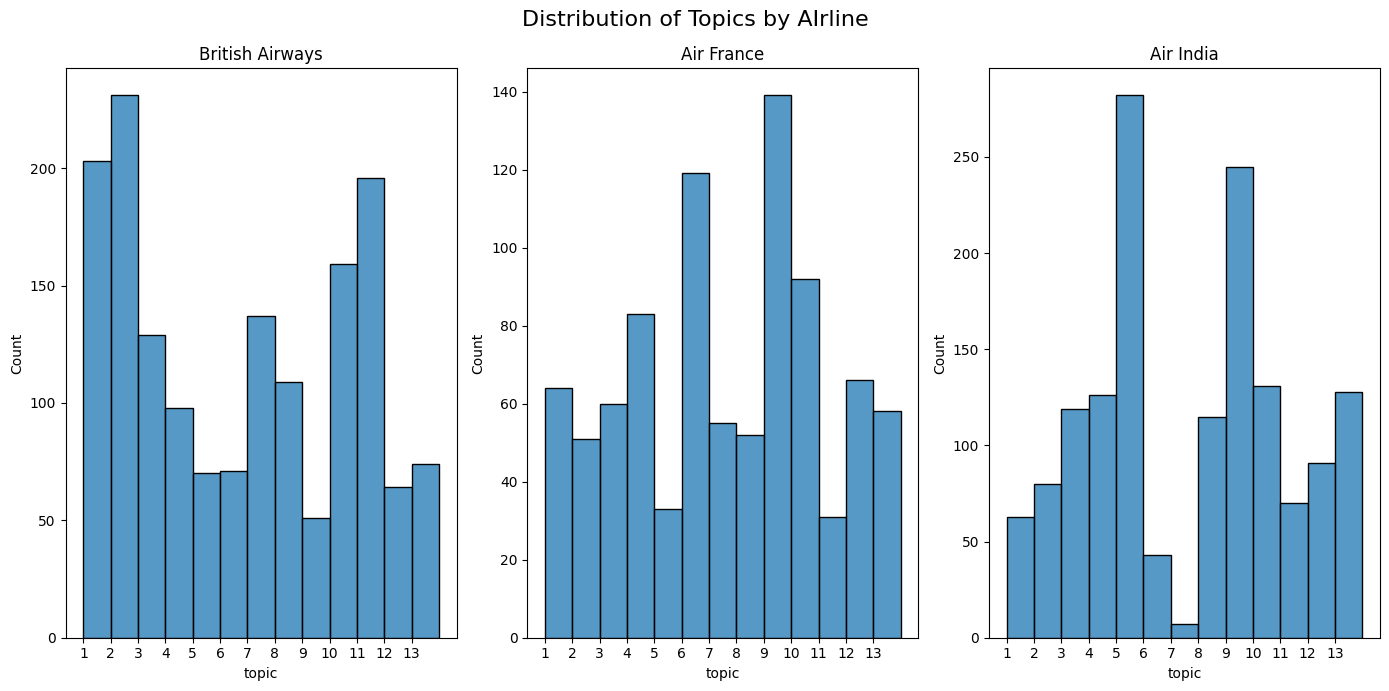

In [72]:
#applying nmf to the reviews
nmf_W.argmax(axis=1)
df_predicted = df_reviews.copy()
df_predicted['topic'] = nmf_W.argmax(axis=1)

#plotting topics by airline
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
fig.suptitle('Distribution of Topics by AIrline', fontsize=16)
airlines = df_reviews['airline'].unique()
for i, airline in enumerate(airlines):
    ax = axs[i]
    sns.histplot(data=df_predicted[df_predicted['airline'] == airline], x='topic', ax=ax, label='Topic', bins=range(n_components+1))
    ax.set_title(airline)
    ax.set_xticks(range(n_components))
    ax.set_xticklabels(range(1, n_components+1))
plt.tight_layout()
plt.show()

In [73]:
#collecting top 3 topics by airline
top_issues_airline = df_predicted.groupby('airline')['topic'].value_counts().groupby(level=0).head(3)
top_issues_airline = top_issues_airline.reset_index(name='count')
top_issues_airline['model'] = 'NMF'
top_issues_airline['topic_words'] = top_issues_airline['topic'].map(lambda x: topic_words[x])
top_issues_airline

,airline,topic,count,model,topic_words
0,Air France,8,139,NMF,"ever, rude, terrible, recommend, people, airli..."
1,Air France,5,119,NMF,"luggage, lose, lose luggage, arrive, carry, ha..."
2,Air France,9,92,NMF,"boarding, gate, minute, wait, board, pass, boa..."
3,Air India,4,282,NMF,"work, entertainment, system, entertainment sys..."
4,Air India,8,245,NMF,"ever, rude, terrible, recommend, people, airli..."
5,Air India,9,131,NMF,"boarding, gate, minute, wait, board, pass, boa..."
6,British Airways,1,231,NMF,"class, business, business class, lounge, class..."
7,British Airways,0,203,NMF,"meal, drink, serve, offer, good, long, well, w..."
8,British Airways,10,196,NMF,"crew, cabin, cabin crew, member, crew member, ..."


A few observations:

Topic 9 & 10: Are not specific enough. By further looking at the reviews we can see that some of the reviews are ver long touching multiple items. Therefore, some items reviews could be categorized under multiple topics. Posing a question if we should further limit the length of the reviews or if we can leverage a model that can attribute multiple topics to a review.

Other topics are more specific, like Topic 5 and cleared to categorize. Below is an example of a generic comment and a specific one:

In [14]:
print('Topic 9 - Generice Review:')
print(df_predicted['text'].iloc[37])
print('-------------')
print('\n')
print('Topic 5 - Specific Review:')
print(df_predicted['text'].iloc[144])

Topic 9 - Generice Review:
I spent a fantastic 10-day vacation in Hong Kong with my family, but our return flight with Air France (Flight AF 185) ruined the experience. When we arrived at the check-in counter, we waited over two hours just to receive our boarding passes. Then, only an hour before the flight, they informed us that our pre-selected seats had been changed due to a "problem." They assured us the new seats would have extra legroom, though two out of five seats would lack screens. Since we had no other flight options, we reluctantly accepted.

Once we boarded, we discovered our original seats, which had a “problem,” were sold to other passengers—even though we booked the flight three months ago. The new seats were far from an upgrade. Two of them were actually intended for staff, with no screens, no USB ports, and awkwardly positioned in the middle of the aisle—not ideal for a 13-hour flight. Because of this awkward placement, passengers frequently stepped on my foot wheneve

### 3.3. BERTopic
BERTopic  is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

As I researched different approaches for topic modeling, BERTopic stood out for it's robustness, easy of use and graphical visualizations and the ability to calculate probabilities for different topics. The method doesn't require for the number of components to be specificied upfront, allows for topics to be clustered after the initial fitiing, making it a great starting point for modeling.

We'll use the cleaned_text from the EDA analysis, but will rely on BERTopics TF-IDF function instead of leveraging the TF-IDF matrix previously created for the NMF.

The outcomes of BERTopic help me understand what would be a reasonable number of topics to refine the NMF model.


In [5]:
# !pip install bertopic
# from bertopic import BERTopic
df_reviews = pd.read_csv('cleaned_reviews.csv')
topic_model = BERTopic(n_gram_range=(1, 2))
topics, probs = topic_model.fit_transform(df_reviews['cleaned_text'])
topic_model.visualize_topics()

# topic_model.visualize_barchart()

#### 3.3.1. Removing outliers & reducing topics

As seen above, the model produced 34 topics. In the distance map, we can see the size of each topic in reviews and close they are to each other. The model also produces a topic numbered -1, which includes outliers that will be removed in this step We can see that removing outliers, and after we'll go ahead and reduce the topics automatically.

In [6]:
topic_model.get_topic_info(-1)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2056,-1_flight_seat_service_airline,"[flight, seat, service, airline, hour, time, f...",[september first kuala lumpur flight initial...


In [17]:
#removing outliers
new_topics = topic_model.reduce_outliers(df_reviews['cleaned_text'].tolist(), topics)
topic_model.update_topics(df_reviews['cleaned_text'].tolist(), topics=new_topics)

#reducing topics
topic_model.reduce_topics(df_reviews['cleaned_text'])
topic_model.visualize_topics()

2025-04-17 02:51:01,087 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [18]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1350,0_flight_food_seat_service,"[flight, food, seat, service, hour, airline, t...",[kiev last two flight airway nightmare first f...
1,1,470,1_cancel_flight_refund_book,"[cancel, flight, refund, book, ticket, custome...",[request refund passenger travel one passeng...
2,2,404,2_flight_delay_hour_time,"[flight, delay, hour, time, flight delay, conn...",[ flight delay cumulated time hour minu...
3,3,386,3_luggage_baggage_lose_arrive,"[luggage, baggage, lose, arrive, flight, call,...",[never choice never suppose american airline c...
4,4,334,4_class_business_business class_seat,"[class, business, business class, seat, econom...",[book think business class seat flight premium...
5,5,324,5_seat_flight_airline_leg,"[seat, flight, airline, leg, book, check, chan...",[seat selection front month back seat front ec...
6,6,214,6_staff_rude_service_flight,"[staff, rude, service, flight, airline, ever, ...",[never flight ever airline staff staff polite ...
7,7,126,7_call_customer_customer service_service,"[call, customer, customer service, service, ch...",[essentially customer service change ticket so...
8,8,83,8_check_queue_counter_staff,"[check, queue, counter, staff, flight, gate, b...",[check flight check process disgusting minut...
9,9,61,9_economy_premium_premium economy_seat,"[economy, premium, premium economy, seat, flig...",[book eur flight premium economy hong ko...


We end up with 20 topics. Many are relevant, but we still have too many little topics so the model could benefit from further improvement. The benefit of using BERTopic is being able to see the probability of a document regarding a assigned topic. When looking at the previous review examples we can see how relevant the topic modeling has been to each review.

Below we'll print the probability for the generic review and the specific review from the NMF model. Notice how high the probability of the specific review is vs. how low it is for the generic one.

In [19]:
print('Generic Review:')
print(topic_model.get_document_info(df_reviews['cleaned_text']).iloc[37])
print('-------------')
print('\n')
print('Specific Review:')
print(df_predicted['text'].iloc[144])
print(topic_model.get_document_info(df_reviews['cleaned_text']).iloc[144])

Generic Review:
Document                   spend fantastic   vacation hong kong family re...
Topic                                                                      0
Name                                              0_flight_food_seat_service
Representation             [flight, food, seat, service, hour, airline, t...
Representative_Docs        [kiev last two flight airway nightmare first f...
Top_n_words                flight - food - seat - service - hour - airlin...
Probability                                                              0.0
Representative_document                                                False
Name: 37, dtype: object
-------------


Specific Review:
Worst experience for luggage arrival , after landing flight luggage will come after 1 hrs
No staff at airport to handel luggage.  Onward journey program is delay due to  air India bad service. I found this problem frequently in ahemdabad airport last one yr.
Document                   experience luggage arriva

#### 3.3.2. Levergaging K-means with BERTopic
Alternatively, we can leverage K-means as the clustering engine behind BERTopic.
For this example, we are limiting the number of clusters to 20 based on all the previous analysis done for the other models.

In [20]:
#clustering
from sklearn.cluster import KMeans
n_components = 20
cluster_model = KMeans(n_clusters=n_components)
k_topic_model = BERTopic(hdbscan_model=cluster_model, n_gram_range=(1, 2))
k_topics, k_probs = k_topic_model.fit_transform(df_reviews['cleaned_text'])
k_topic_model.visualize_topics()

In [21]:
k_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,310,0_delay_flight_hour_time,"[delay, flight, hour, time, late, miss, flight...",[ticket booking indicate hour time book ye...
1,1,294,1_refund_cancel_flight_book,"[refund, cancel, flight, book, ticket, call, c...",[book website round trip flight stop business ...
2,2,282,2_seat_economy_flight_premium,"[seat, economy, flight, premium, airline, food...",[start charge food drink short haul flight mig...
3,3,278,3_food_work_flight_entertainment,"[food, work, flight, entertainment, plane, sea...",[put mildly experience flight terrible tray ta...
4,4,257,4_staff_rude_flight_travel,"[staff, rude, flight, travel, service, check, ...",[international flight travail toddler inco...
5,5,237,5_class_business_business class_seat,"[class, business, business class, seat, econom...",[wife book two round trip business class ticke...
6,6,237,6_flight_seat_service_crew,"[flight, seat, service, crew, food, time, airl...",[since year go back forth least time year ...
7,7,236,7_flight_customer_airline_service,"[flight, customer, airline, service, book, cus...",[customer service exist one world frequent lon...
8,8,233,8_flight_call_cancel_book,"[flight, call, cancel, book, ticket, customer,...",[today th july find need change travel date th...
9,9,213,9_food_meal_flight_serve,"[food, meal, flight, serve, drink, service, cr...",[request asian vegetarian food include return ...


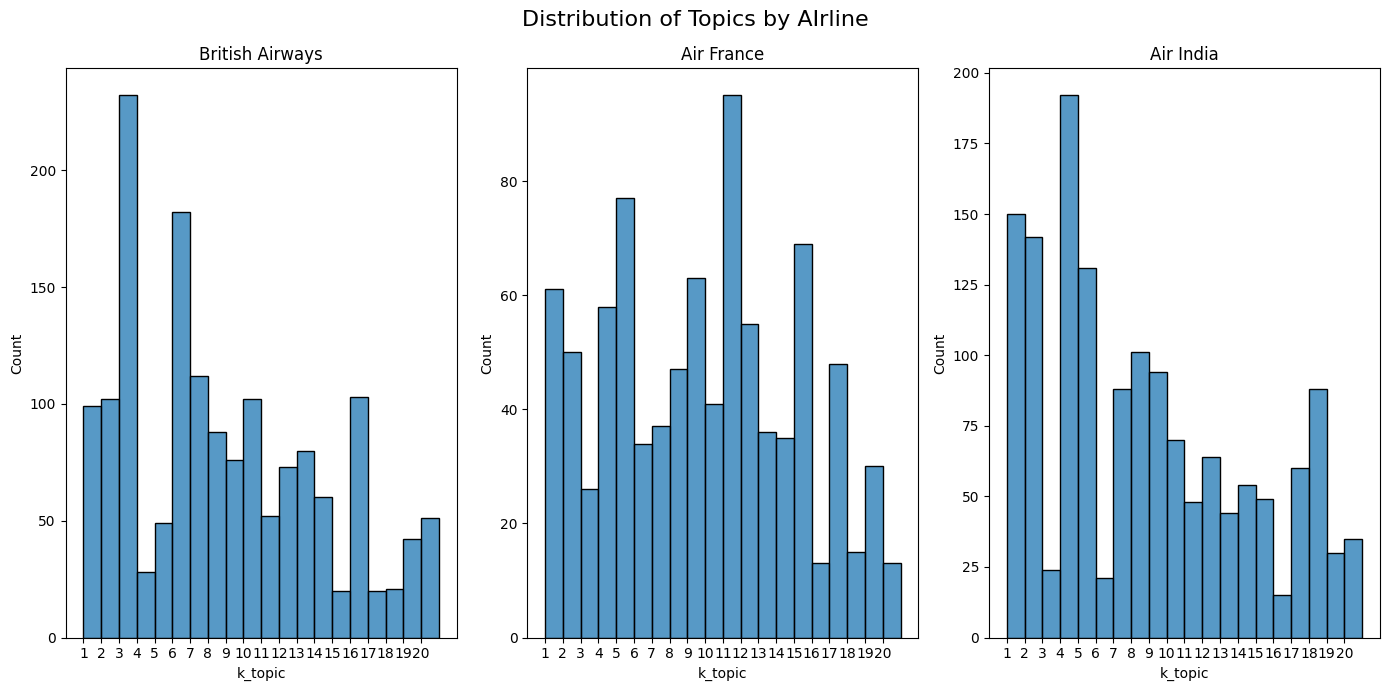

In [22]:
#categorizing the dataset
df_bert_predicted = df_reviews.copy()
df_bert_predicted['b_topic'] = topic_model.topics_
df_bert_predicted['k_topic'] = k_topic_model.topics_


#plotting topics by airline
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
fig.suptitle('Distribution of Topics by AIrline', fontsize=16)
airlines = df_reviews['airline'].unique()

for i, airline in enumerate(airlines):
    ax = axs[i]
    sns.histplot(data=df_bert_predicted[df_bert_predicted['airline'] == airline], x='k_topic', ax=ax, label='Topic', bins=range(n_components+1))
    ax.set_title(airline)
    ax.set_xticks(range(n_components))
    ax.set_xticklabels(range(1, n_components+1))
plt.tight_layout()
plt.show()

# k_topic_model.visualize_barchart(top_n_topics=n_components)

In [ ]:
#getting only the word of topic_representations
def get_representations(model, i):
  representations = []
  for row in model.topic_representations_[i]:
    representation = row[0]
    representations.append(representation)

  #comma separated values in a string format
  rep = ', '.join(representations)
  return rep

#top 3 topics by model
k_top_issues_airline = df_bert_predicted.groupby('airline')['topic'].value_counts().groupby(level=0).head(3)
k_top_issues_airline = k_top_issues_airline.reset_index(name='count')
k_top_issues_airline['topic_words'] = k_top_issues_airline['topic'].map(lambda x: get_representations(k_topic_model, x))
k_top_issues_airline['model'] = 'K-BERTopic'

b_top_issues_airline = df_bert_predicted.groupby('airline')['topic'].value_counts().groupby(level=0).head(3)
b_top_issues_airline = b_top_issues_airline.reset_index(name='count')
b_top_issues_airline['topic_words'] = b_top_issues_airline['topic'].map(lambda x: get_representations(topic_model, x))
b_top_issues_airline['model'] = 'BERTopic'


## 4.Discussion & Conclusion
Here is a final look on the top topics by airline and model. Notice how the top topic by airline and model have some overlap. FOr example: AirFrance issues with lost lugagge has been a top issue in all the models, staff being rude was a top issue for this airline as well for 2 of the models. For Air India, flight delays was an issue flag by all models, with issues with entertainment system being flagged by 2 of the models. For British Airways, issues with the Business Class and the longe were flagged by the 3 models, and complaints about the crew and onboard service were also flagged by all the models.  Showing how relevant Topic Modeling can be to encounter issues and improve customer service.


In [77]:
#joining all the  top_issues tables getting only topic_words & model
final_issues_airline = pd.concat([top_issues_airline, k_top_issues_airline, b_top_issues_airline])
grouped_df = final_issues_airline.groupby(['airline', 'model','topic_words']).size().reset_index(name='count')
grouped_df

,airline,model,topic_words,count
0,Air France,BERTopic,"cancel, flight, refund, book, ticket, customer...",1
1,Air France,BERTopic,"flight, food, seat, service, hour, airline, ti...",1
2,Air France,BERTopic,"luggage, baggage, lose, arrive, flight, call, ...",1
3,Air France,K-BERTopic,"luggage, baggage, call, lose, arrive, tell, fl...",1
4,Air France,K-BERTopic,"luggage, baggage, check, carry, kg, airline, f...",1
5,Air France,K-BERTopic,"staff, rude, flight, travel, service, check, a...",1
6,Air France,NMF,"boarding, gate, minute, wait, board, pass, boa...",1
7,Air France,NMF,"ever, rude, terrible, recommend, people, airli...",1
8,Air France,NMF,"luggage, lose, lose luggage, arrive, carry, ha...",1
9,Air India,BERTopic,"cancel, flight, refund, book, ticket, customer...",1


### Learnings

**EDA & Normalization**

*   By leveraging the right techniques we were able to drastically reduce the number of features in our initial dataset.
*   When normalizing the data, we decided to include bigrams, making the number of features grow exponentially. It was crucial to tune the hyperparameters `min_df` and `max_df` to get to a resonable number of features. Tuning `min_df` prooved to be more impactful than `max_df`.


**Building the Models**

*   Non-Negative Matrix Factorization proved to be a powerful approach to model the topics from customer's bad reviews. The dowside of he model is having to define the number of topics upfront, but because it is so fast to train, iterating on it proves an effective way to find a reasonable number of components.
*   BERTopic doesn't require the number of components to be defined upfront and comes with normalization methods and several visualization tools, making it a powerful tool for topic modeling. Beyond the standard methods, BERTopic allows leveraging other methods, like k-means for clustering.
*   BERTopic attributes probabilities for to every reviewed observation, making it easier to understand how sure the model is for the predicted topic, helping with understanding of the outcomes and future model improvement.

### Next Steps
*   **Dealing with large reviews:** During the modeling, it was possible to notice that the models struggled with larger reviews, possibly containing multiple topics, if we want to further improve the models, there needs to be an approach to dealing with these observations.

*   **Dealing with small topics:** BERTopic generated 20 different topics, many of them only relevant to a small set of reviews, if we want to reduce the number of topics generated by the model, further topic combining and reduction might be beneficial.

*  **Productionizing:** While topic modeling is extremely insightful and helpful to categorize reviews, if we were to productionize an approach, we should use the outcomes of this model as input to a supervised learning method, constantly reviewing the pipeline of feedbacks to check for new topics that mugh arise.